# Task 2.2: Model Building - Credit Card Fraud Detection

## Objective
Build and evaluate classification models for bank credit card fraud detection:
1. Train a **baseline** model (Logistic Regression)
2. Train an **ensemble** model (Random Forest)
3. Compare models and select the best

## Dataset Characteristics
- Features are **anonymized PCA components** (V1-V28) plus `Time` and `Amount`
- All features are **numeric** (simpler preprocessing)
- Highly imbalanced (typical for credit card fraud)

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# Project imports
from src.data.loader import load_creditcard_data
from src.modeling.pipelines import build_creditcard_pipeline, get_model_name
from src.modeling.train import train_and_evaluate, cross_validate_model, save_model, compare_models
from src.modeling.metrics import (
    plot_confusion_matrix,
    plot_precision_recall_curve,
    get_classification_report_df,
)

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

RANDOM_STATE = 42

## 1. Load Credit Card Data

In [2]:
# Load the credit card dataset
DATA_PATH = project_root / "data" / "raw" / "creditcard.csv"

df = load_creditcard_data(DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check class distribution
print("Class Distribution:")
class_counts = df['Class'].value_counts()
print(class_counts)
print(f"\nFraud rate: {df['Class'].mean() * 100:.4f}%")
print(f"Imbalance ratio: 1:{class_counts[0] / class_counts[1]:.0f}")

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Fraud rate: 0.1727%
Imbalance ratio: 1:578


In [4]:
# Define features and target
# V1-V28 are PCA components, Time and Amount are the only interpretable features
FEATURE_COLS = [col for col in df.columns if col != 'Class']
TARGET = 'Class'

print(f"Features: {len(FEATURE_COLS)} columns")
print(f"Feature names: {FEATURE_COLS}")

Features: 30 columns
Feature names: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [5]:
# Prepare X and y
X = df[FEATURE_COLS].copy()
y = df[TARGET].copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (284807, 30)
y shape: (284807,)


In [6]:
from IPython.display import Markdown, display

fraud_rate = df['Class'].mean() * 100
imbalance_ratio = class_counts[0] / class_counts[1]

display(
    Markdown(
        f"""
### Interpretation: Credit Card Dataset Overview

- **Dataset size**: `{df.shape[0]:,}` transactions × `{df.shape[1]}` columns
- **Fraud rate**: `{fraud_rate:.4f}%` (highly imbalanced)
- **Imbalance ratio**: approximately **1:{imbalance_ratio:.0f}**
- **Features**: `V1`-`V28` (PCA components, anonymized), `Time`, `Amount`

**Note on interpretability**
- The V1-V28 features are the result of PCA transformation for privacy.
- Only `Time` and `Amount` have direct business meaning.
- SHAP analysis will still show which components drive predictions, but interpretation is abstract.
"""
    )
)


### Interpretation: Credit Card Dataset Overview

- **Dataset size**: `284,807` transactions × `31` columns
- **Fraud rate**: `0.1727%` (highly imbalanced)
- **Imbalance ratio**: approximately **1:578**
- **Features**: `V1`-`V28` (PCA components, anonymized), `Time`, `Amount`

**Note on interpretability**
- The V1-V28 features are the result of PCA transformation for privacy.
- Only `Time` and `Amount` have direct business meaning.
- SHAP analysis will still show which components drive predictions, but interpretation is abstract.


## 2. Train-Test Split (Stratified)

In [7]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Training set: 227,845 samples
Test set: 56,962 samples

Training class distribution:
Class
0    227451
1       394
Name: count, dtype: int64

Test class distribution:
Class
0    56864
1       98
Name: count, dtype: int64


## 3. Baseline Model: Logistic Regression

In [8]:
# Build logistic regression pipeline with SMOTE
lr_pipeline = build_creditcard_pipeline(
    model_type="logistic",
    use_smote=True,
    random_state=RANDOM_STATE,
)

print("Logistic Regression Pipeline:")
print(lr_pipeline)

Logistic Regression Pipeline:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])


In [9]:
# Train and evaluate
print("Training Logistic Regression...")
lr_model, lr_metrics, lr_threshold = train_and_evaluate(
    lr_pipeline,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
)

print("\nLogistic Regression Results:")
for key, value in lr_metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Training Logistic Regression...

Logistic Regression Results:
  precision: 0.0578
  recall: 0.9184
  f1: 0.1088
  tn: 55397
  fp: 1467
  fn: 8
  tp: 90
  auc_pr: 0.7245
  roc_auc: 0.9708
  threshold: 0.5000


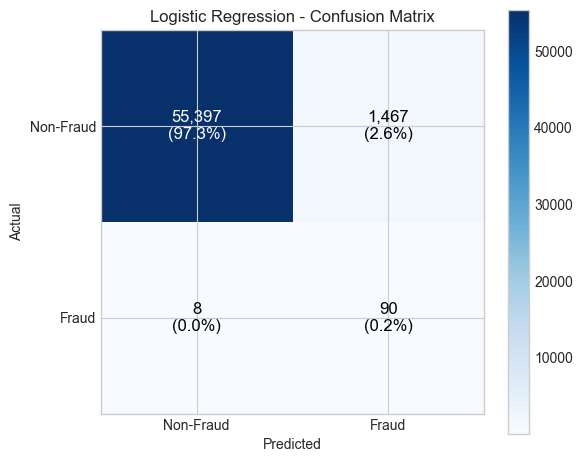

In [10]:
# Confusion matrix
y_pred_lr = lr_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test.values, y_pred_lr, title="Logistic Regression - Confusion Matrix", ax=ax)
plt.tight_layout()
plt.show()

In [11]:
# Classification report
print("Classification Report - Logistic Regression:")
display(get_classification_report_df(y_test.values, y_pred_lr))

Classification Report - Logistic Regression:


,precision,recall,f1-score,support
Non-Fraud,0.999856,0.974202,0.986862,56864.000000
Fraud,0.057803,0.918367,0.108761,98.000000
accuracy,0.974106,0.974106,0.974106,0.974106
macro avg,0.528830,0.946284,0.547812,56962.000000
weighted avg,0.998235,0.974106,0.985351,56962.000000


## 4. Ensemble Model: Random Forest

In [12]:
# Build Random Forest pipeline with SMOTE
rf_pipeline = build_creditcard_pipeline(
    model_type="random_forest",
    use_smote=True,
    random_state=RANDOM_STATE,
    n_estimators=100,
    max_depth=10,
)

print("Random Forest Pipeline:")
print(rf_pipeline)

Random Forest Pipeline:
Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, n_jobs=-1,
                                        random_state=42))])


In [13]:
# Train and evaluate
print("Training Random Forest...")
rf_model, rf_metrics, rf_threshold = train_and_evaluate(
    rf_pipeline,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
)

print("\nRandom Forest Results:")
for key, value in rf_metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

Training Random Forest...

Random Forest Results:
  precision: 0.4541
  recall: 0.8571
  f1: 0.5936
  tn: 56763
  fp: 101
  fn: 14
  tp: 84
  auc_pr: 0.8089
  roc_auc: 0.9829
  threshold: 0.5000


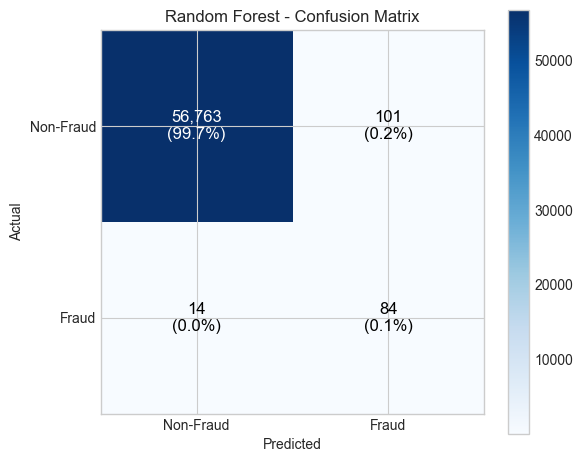

In [14]:
# Confusion matrix
y_pred_rf = rf_model.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 5))
plot_confusion_matrix(y_test.values, y_pred_rf, title="Random Forest - Confusion Matrix", ax=ax)
plt.tight_layout()
plt.show()

In [15]:
# Classification report
print("Classification Report - Random Forest:")
display(get_classification_report_df(y_test.values, y_pred_rf))

Classification Report - Random Forest:


,precision,recall,f1-score,support
Non-Fraud,0.999753,0.998224,0.998988,56864.000000
Fraud,0.454054,0.857143,0.593640,98.000000
accuracy,0.997981,0.997981,0.997981,0.997981
macro avg,0.726904,0.927683,0.796314,56962.000000
weighted avg,0.998815,0.997981,0.998291,56962.000000


## 5. Model Comparison

In [16]:
# Compare all models
results = {
    "Logistic Regression + SMOTE": lr_metrics,
    "Random Forest + SMOTE": rf_metrics,
}

comparison_df = compare_models(results)
print("Model Comparison (sorted by AUC-PR):")
display(comparison_df.round(4))

Model Comparison (sorted by AUC-PR):


,auc_pr,roc_auc,f1,precision,recall,threshold
model,,,,,,
Random Forest + SMOTE,0.8089,0.9829,0.5936,0.4541,0.8571,0.5
Logistic Regression + SMOTE,0.7245,0.9708,0.1088,0.0578,0.9184,0.5


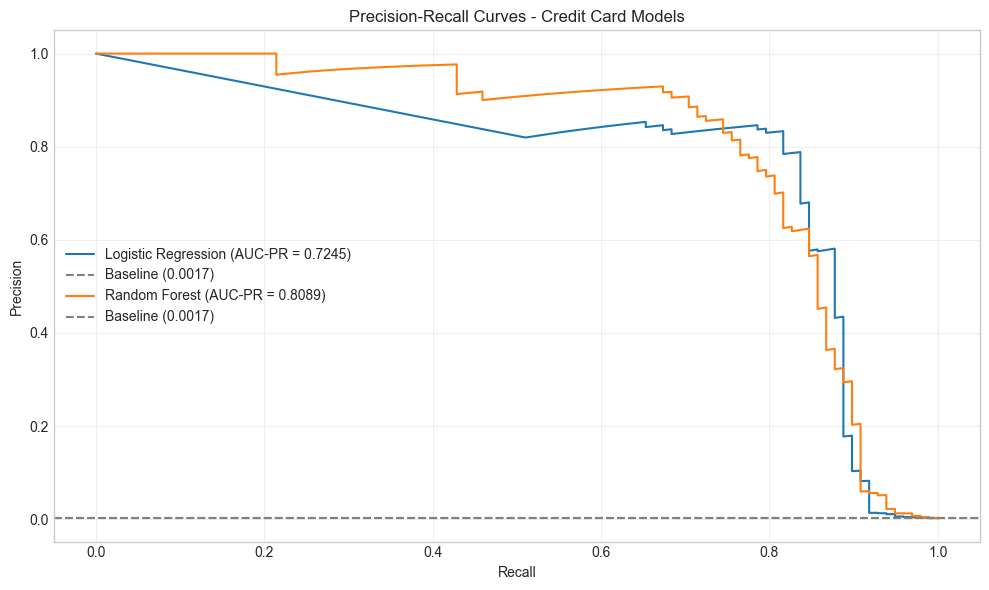

In [17]:
# Precision-Recall curves comparison
fig, ax = plt.subplots(figsize=(10, 6))

y_proba_lr = lr_model.predict_proba(X_test)[:, 1]
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

plot_precision_recall_curve(y_test.values, y_proba_lr, model_name="Logistic Regression", ax=ax)
plot_precision_recall_curve(y_test.values, y_proba_rf, model_name="Random Forest", ax=ax)

ax.legend(loc="best")
ax.set_title("Precision-Recall Curves - Credit Card Models")
plt.tight_layout()
plt.show()

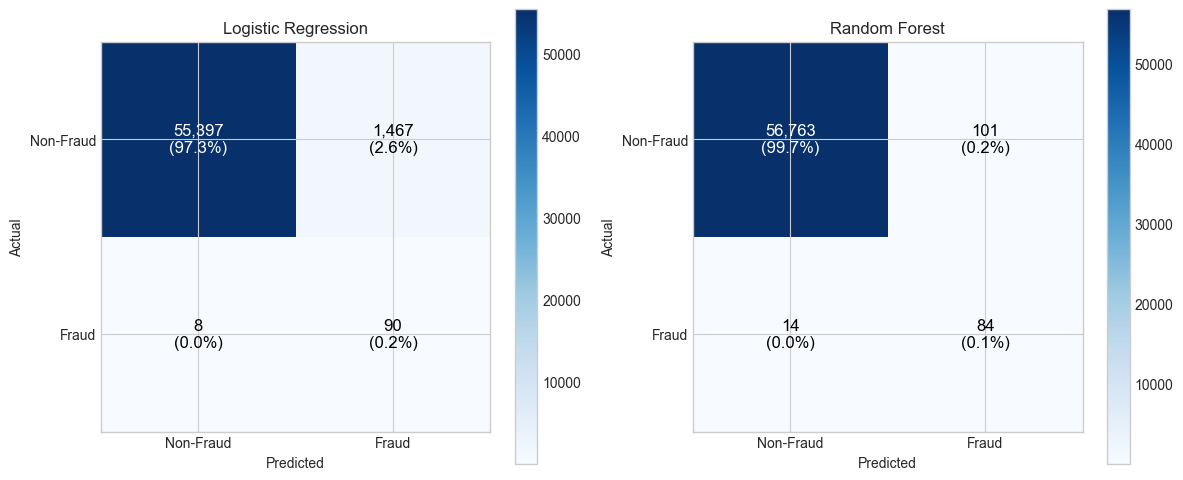

In [18]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_confusion_matrix(y_test.values, y_pred_lr, title="Logistic Regression", ax=axes[0])
plot_confusion_matrix(y_test.values, y_pred_rf, title="Random Forest", ax=axes[1])

plt.tight_layout()
plt.show()

In [19]:
from IPython.display import Markdown, display

best_model_name = comparison_df.index[0]
best_auc_pr = comparison_df.iloc[0]['auc_pr']

lr_auc = lr_metrics.get('auc_pr', 0)
rf_auc = rf_metrics.get('auc_pr', 0)

display(
    Markdown(
        f"""
### Interpretation: Model Comparison (Credit Card)

| Model | AUC-PR | F1 | Precision | Recall |
|-------|--------|----|-----------|---------|
| Logistic Regression | {lr_metrics.get('auc_pr', 0):.4f} | {lr_metrics.get('f1', 0):.4f} | {lr_metrics.get('precision', 0):.4f} | {lr_metrics.get('recall', 0):.4f} |
| Random Forest | {rf_metrics.get('auc_pr', 0):.4f} | {rf_metrics.get('f1', 0):.4f} | {rf_metrics.get('precision', 0):.4f} | {rf_metrics.get('recall', 0):.4f} |

**Best Model**: `{best_model_name}` with AUC-PR = `{best_auc_pr:.4f}`

**Observations**
- Credit card fraud detection with PCA features often shows strong baseline performance.
- The ensemble model captures additional patterns in the anonymized feature space.
- Both models benefit from SMOTE to handle the extreme class imbalance.
"""
    )
)


### Interpretation: Model Comparison (Credit Card)

| Model | AUC-PR | F1 | Precision | Recall |
|-------|--------|----|-----------|---------|
| Logistic Regression | 0.7245 | 0.1088 | 0.0578 | 0.9184 |
| Random Forest | 0.8089 | 0.5936 | 0.4541 | 0.8571 |

**Best Model**: `Random Forest + SMOTE` with AUC-PR = `0.8089`

**Observations**
- Credit card fraud detection with PCA features often shows strong baseline performance.
- The ensemble model captures additional patterns in the anonymized feature space.
- Both models benefit from SMOTE to handle the extreme class imbalance.


## 6. Feature Importance (Random Forest)

In [20]:
# Extract feature importance
rf_classifier = rf_model.named_steps['classifier']
importances = rf_classifier.feature_importances_

importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 15 Features by Importance:")
display(importance_df.head(15))

Top 15 Features by Importance:


,feature,importance
14,V14,0.212026
10,V10,0.117602
4,V4,0.104844
12,V12,0.096115
17,V17,0.095591
3,V3,0.065540
11,V11,0.048512
16,V16,0.046847
2,V2,0.038552
9,V9,0.025488


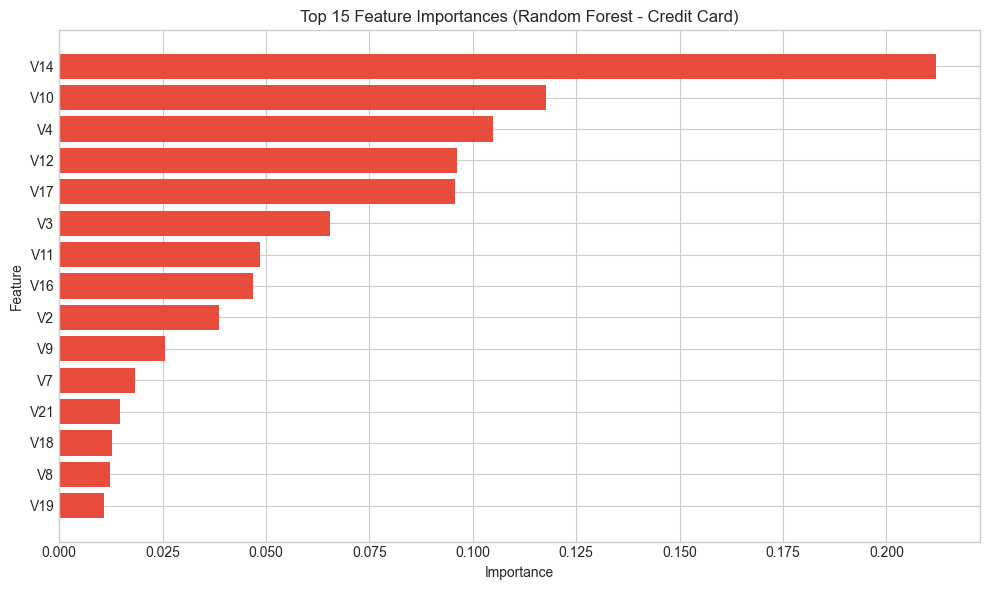

In [21]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_features['feature'], top_features['importance'], color='#e74c3c')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title(f'Top {top_n} Feature Importances (Random Forest - Credit Card)')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [22]:
from IPython.display import Markdown, display

top5 = importance_df.head(5)['feature'].tolist()

display(
    Markdown(
        f"""
### Interpretation: Feature Importance (Credit Card)

**Top 5 most important features**:
1. `{top5[0]}`
2. `{top5[1]}`
3. `{top5[2]}`
4. `{top5[3]}`
5. `{top5[4]}`

**Note on interpretation**
- Since V1-V28 are PCA-transformed, we cannot directly interpret what they represent.
- If `Amount` or `Time` rank highly, those are actionable features.
- SHAP analysis in Task 3 will provide more granular insights into prediction drivers.
"""
    )
)


### Interpretation: Feature Importance (Credit Card)

**Top 5 most important features**:
1. `V14`
2. `V10`
3. `V4`
4. `V12`
5. `V17`

**Note on interpretation**
- Since V1-V28 are PCA-transformed, we cannot directly interpret what they represent.
- If `Amount` or `Time` rank highly, those are actionable features.
- SHAP analysis in Task 3 will provide more granular insights into prediction drivers.


## 7. Save Best Model

In [23]:
# Save models
models_dir = project_root / "models"

# Save Random Forest
rf_path = save_model(rf_model, "creditcard_random_forest", rf_metrics, models_dir)
print(f"Random Forest saved to: {rf_path}")

# Save Logistic Regression
lr_path = save_model(lr_model, "creditcard_logistic_regression", lr_metrics, models_dir)
print(f"Logistic Regression saved to: {lr_path}")

Random Forest saved to: /Users/macbookpro/Documents/Fraud-Detection-system/models/creditcard_random_forest.joblib
Logistic Regression saved to: /Users/macbookpro/Documents/Fraud-Detection-system/models/creditcard_logistic_regression.joblib


## 8. Summary: Task 2 (Credit Card) Complete

In [24]:
from IPython.display import Markdown, display

best_model_name = comparison_df.index[0]
best_metrics = results[best_model_name]

display(
    Markdown(
        f"""
## Summary: Task 2 - Credit Card Fraud Model

### Models Trained
1. **Logistic Regression + SMOTE** (baseline)
2. **Random Forest + SMOTE** (ensemble)

### Best Model: `{best_model_name}`
- **AUC-PR**: `{best_metrics.get('auc_pr', 0):.4f}`
- **F1-Score**: `{best_metrics.get('f1', 0):.4f}`
- **Precision**: `{best_metrics.get('precision', 0):.4f}`
- **Recall**: `{best_metrics.get('recall', 0):.4f}`

### Dataset Characteristics
- `{df.shape[0]:,}` transactions with `{fraud_rate:.4f}%` fraud rate
- Features are PCA-transformed (V1-V28) plus Time and Amount
- Extreme imbalance handled with SMOTE

### Files Saved
- `models/creditcard_random_forest.joblib`
- `models/creditcard_logistic_regression.joblib`

### Next Steps
- Proceed to Task 3 for SHAP explainability analysis
- Focus SHAP analysis on the e-commerce model (more interpretable features)
"""
    )
)


## Summary: Task 2 - Credit Card Fraud Model

### Models Trained
1. **Logistic Regression + SMOTE** (baseline)
2. **Random Forest + SMOTE** (ensemble)

### Best Model: `Random Forest + SMOTE`
- **AUC-PR**: `0.8089`
- **F1-Score**: `0.5936`
- **Precision**: `0.4541`
- **Recall**: `0.8571`

### Dataset Characteristics
- `284,807` transactions with `0.1727%` fraud rate
- Features are PCA-transformed (V1-V28) plus Time and Amount
- Extreme imbalance handled with SMOTE

### Files Saved
- `models/creditcard_random_forest.joblib`
- `models/creditcard_logistic_regression.joblib`

### Next Steps
- Proceed to Task 3 for SHAP explainability analysis
- Focus SHAP analysis on the e-commerce model (more interpretable features)
